# Box-Cox Transformation Experiment Notebook

This is the experiment using **Box-Cox Transformation** with 4 Digit MWC 4 Dataset. We have already experimented the transform using **logit function** `ln(x/(1-x))` but there are some beatmap that don't have the **Normally Distributed** score yet. So we try a (hopefully not too) complicated approach to make the data more Normally Distributed

---

## Procedure

In [1]:
import os

os.chdir("..")

### Import Necessary Libraries

Here we are going to use `matplotlib.pyplot` to visualize the distribution of the data and `Dataset`class from [this repository](https://github.com/HowToProgramming/4dm4analysis) to deal with `sqlite` database

In [2]:
import matplotlib.pyplot as plt
from utils import Dataset

### Initialize the Dataset

In [3]:
_4dm4 = Dataset('datasets/4dm4.db')

### Define the Necessary functions to Query Data

- `query_by_round_type_tag` is used to query `player_name`, `score` and `score_logit` from the dataset where the maps are `round`, `type`, `tag` (for example `SF`, `HB`, `2`)
- `query_all_tags` is to query the map count of a `type` in a given `round`

In [4]:
def query_by_round_type_tag(round: str, type: str, tag: str):
    return _4dm4.select('scores', columns=['player_name', 'score', 'score_logit'], where={
        'round': f"\"{round}\"",
        'beatmap_type': f"\"{type}\"",
        'beatmap_tag': f"\"{tag}\""
    })

def query_all_tags(round: str, type: str):
    return _4dm4.query(f'SELECT DISTINCT beatmap_tag FROM scores WHERE round=\"{round}\" AND beatmap_type=\"{type}\"')

We test if the following functions work

In [5]:
query_by_round_type_tag("QF", "HB", "1").head()

,player_name,score,score_logit
0,Scep,998615,6.580669
1,[-Leon-],997713,6.078225
2,diamondBIaze,996846,5.755925
3,ZayyKen,996626,5.688277
4,Yuragi,996232,5.577436


In [6]:
query_all_tags("QF", "HB")

,beatmap_tag
0,1
1,2


### Defining Constants

We then define the `interested_rounds` we want to study (which is all rounds) and `interested_category` to be `RC`, `HB` and `LN`

In [7]:
interested_rounds = _4dm4.query("SELECT DISTINCT round FROM SCORES").values.flatten().tolist()
interested_category = ['RC', 'HB', 'LN']

interested_rounds

['Q', 'GS', 'RO16', 'QF', 'SF', 'F', 'GF']

---

### Shapiro-Wilk test

We perform the **Shapiro-Wilk test** to check whether the data is **Normally Distributed** basically if the `scipy.stats.shapiro` yields the `p-value` **less than 0.05**, we can say that the data is not Normally Distributed. Otherwise...

*There is no turning back*

In [8]:
from scipy.stats import shapiro

We pull data (`score` and `score_logit`) from **QF RC 1** as a sample data

In [9]:
qf_rc_1 = query_by_round_type_tag('QF', 'RC', 1)

qf_rc_1_score = qf_rc_1['score'].values.flatten()
qf_rc_1_score_logit = qf_rc_1['score_logit'].values.flatten()

Then we perform the **Shapiro-Wilk test** on these data

In [10]:
shapiro(qf_rc_1_score)

ShapiroResult(statistic=0.8907632827758789, pvalue=0.013783573172986507)

In [11]:
shapiro(qf_rc_1_score_logit)

ShapiroResult(statistic=0.9694371223449707, pvalue=0.6531001329421997)

As we seen from **QF RC 1**, the raw score is not **Normally Distributed** but the transformation using **logit function** did a really good job on normalizing the dataset. Let's see if it works for all beatmaps.

### Logit transformation always works ?

Here, we use **Shapiro-Wilk test** to verify that every beatmap has the Normally Distributed score (from logit transformation). We loop over all rounds, interested types and tags and print the beatmap that has the **p-value < 0.05** even with the **logit transformation**.

In [12]:
for rnd in interested_rounds:
    for cat in interested_category:
        tags = query_all_tags(rnd, cat).values.flatten()
        for t in tags:
            ds = query_by_round_type_tag(rnd, cat, t)
            stat, p = shapiro(ds['score_logit'].values.flatten())
            if p < 0.05:
                print(rnd, cat, t)
                print("Score", shapiro(ds['score'].values.flatten()))
                print("Logit Score", shapiro(ds['score_logit'].values.flatten()))

Q RC 1
Score ShapiroResult(statistic=0.3490583896636963, pvalue=1.3160818680594503e-35)
Logit Score ShapiroResult(statistic=0.9774777293205261, pvalue=5.725646133214468e-06)
Q LN 1
Score ShapiroResult(statistic=0.37814944982528687, pvalue=3.398193377752854e-26)
Logit Score ShapiroResult(statistic=0.5216010808944702, pvalue=1.7381581325353384e-23)
GS RC 2
Score ShapiroResult(statistic=0.7879812121391296, pvalue=3.728700074395741e-12)
Logit Score ShapiroResult(statistic=0.9779815077781677, pvalue=0.03891284018754959)
GS RC 3
Score ShapiroResult(statistic=0.21162128448486328, pvalue=1.5284648306490443e-22)
Logit Score ShapiroResult(statistic=0.8392794728279114, pvalue=4.240784112763407e-10)
GS RC 4
Score ShapiroResult(statistic=0.18204039335250854, pvalue=2.017119067987077e-27)
Logit Score ShapiroResult(statistic=0.9291901588439941, pvalue=1.0756894397445649e-07)
GS LN 1
Score ShapiroResult(statistic=0.48579829931259155, pvalue=3.58803686692619e-21)
Logit Score ShapiroResult(statistic=0.9

From this code, we can see that there are still many beatmaps which the scores are not **Normally Distributed** even with the **logit transformation**. We need another approach to make them more Normally Distributed.

---

### Box-Cox Transformation

#### What is Box-Cox Transformation ?

The **Box-Cox Transformation** aims to make the data as Normally Distributed as possible using the formula given below

```python
y = (x**lmbda - 1) / lmbda,  for lmbda != 0
    log(x),                  for lmbda = 0
```

The `scipy` python package provides the way to automatically find `lmbda` using **Maximum Likelihood** so we don't need to worry about finding `lmbda`.

For more information, you can read this [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) or [this Medium Article](https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203).

#### Performing Box-Cox Transformation

**Box-Cox Transformation** can be found in `scipy.stats` package

In [13]:
from scipy.stats import boxcox

We observe the **Q RC 1** score that has been transformed using logit function. This beatmap does not have a **Normally Distributed** score_logit.

In [14]:
# q rc1 is not normal

q_rc_1 = query_by_round_type_tag('Q', 'RC', 1)['score_logit']
q_rc_1

0      6.621999
1      6.478995
2      6.353857
3      6.324868
4      6.296693
         ...   
403    1.725103
404    1.704427
405    1.224070
406    0.043807
407   -0.648170
Name: score_logit, Length: 408, dtype: float64

We perform the **Box-Cox Transformation**

In [16]:
bc, lmbda = boxcox(q_rc_1 + 1)

Then we observe the data using **Histogram**

(array([ 2.,  4., 27., 49., 87., 79., 81., 51., 20.,  8.]),
 array([-0.48649832,  1.39328641,  3.27307114,  5.15285587,  7.0326406 ,
         8.91242533, 10.79221006, 12.67199479, 14.55177952, 16.43156424,
        18.31134897]),
 <BarContainer object of 10 artists>)

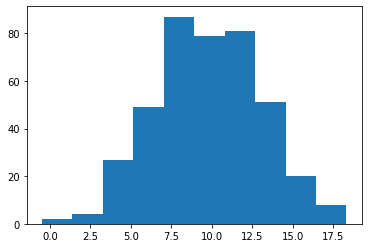

In [17]:
plt.hist(bc)

And do the **Shapiro-Wilk test** with transformed data again

In [18]:
shapiro(bc)

ShapiroResult(statistic=0.9958409070968628, pvalue=0.3576762080192566)

The data looks **Normally Distributed** enough according to **p-value**

Then we observe the `lmbda` we get from **Box-Cox Transformation**

In [19]:
lmbda

1.7116217546963006

#### Does it actually work ?

Here, we use **Shapiro-Wilk test** to verify that every beatmap has the Normally Distributed score (from logit transformation). We loop over all rounds, interested types and tags and print the beatmap that has the **p-value < 0.05** even after the **logit** and **Box-Cox Transformation**.

In [21]:
for rnd in interested_rounds:
    for cat in interested_category:
        tags = query_all_tags(rnd, cat).values.flatten()
        for t in tags:
            ds = query_by_round_type_tag(rnd, cat, t)['score_logit'].values.flatten()
            ds_boxcox, lmbda = boxcox(ds - ds.min() + 0.01)
            stat, p = shapiro(ds)
            stat_bc, p_bc = shapiro(ds_boxcox)
            if p_bc < 0.05:
                print(rnd, cat, t)
                print("p shapiro Logit Score", p)
                print("p shapiro Logit Boxcox", p_bc)
                print("bc lambda", lmbda)

Q LN 1
p shapiro Logit Score 1.7381581325353384e-23
p shapiro Logit Boxcox 5.792896445200313e-06
bc lambda 3.5406503314534286
GS RC 3
p shapiro Logit Score 4.240784112763407e-10
p shapiro Logit Boxcox 0.01173748355358839
bc lambda 2.091448707723908
RO16 RC 5
p shapiro Logit Score 0.030514327809214592
p shapiro Logit Boxcox 0.010086318477988243
bc lambda 0.8126567453383848
RO16 HB 2
p shapiro Logit Score 0.005119670648127794
p shapiro Logit Boxcox 0.0035309172235429287
bc lambda 0.9120669897518988


There are **RO32 RC 3**, **QF RC 2** and **QF RC 5** which are still not normally distributed.

We then observe these beatmaps using **Q-Q Plot** which is the plot to observe the residual from the given distributions (which is Normal Distribution in this case)

Here, we define the function to observe the **Q-Q Plot** of **Original Data** and **Box-Cox Transformed Data**

In [22]:
from scipy.stats import probplot, norm

def qqplotOriginalVSBoxCox(dataset):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    probplot(dataset, dist=norm, plot=ax)
    ax2 = fig.add_subplot(212)
    probplot(boxcox(dataset - dataset.min() + 0.01)[0], dist=norm, plot=ax2)

We then observe all beatmaps that are not **Normally Distributed** even with the **Box-Cox Transformation** and **Logit Transformation**

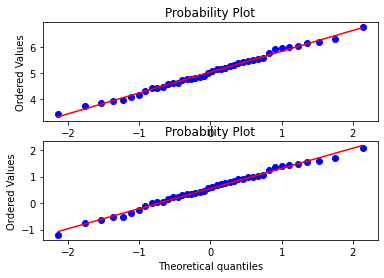

In [24]:
ds = query_by_round_type_tag('QF', 'RC', 5)['score_logit'].values.flatten()

qqplotOriginalVSBoxCox(ds)

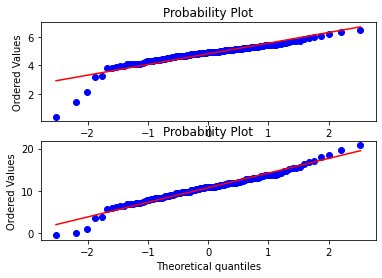

In [26]:
ds = query_by_round_type_tag('GS', 'RC', 3)['score_logit'].values.flatten()

qqplotOriginalVSBoxCox(ds)

---